In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import random
import json
from faker import Faker
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import Lasso
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

# Experiment 2
Person Template:
{
    GroundTruth:
    {
        Hired: 1/0,
        Color: yellow/blue,
        TotalSkill: skillevel,
    }
    Resume:
    {
        Name: name,
        Location: <cities>,
        Education: <Schools>,
        ClassRanking: <ranking>,
        WorkExperience: <work places>,
        TechnicalSkills: <skills>,
        Hobbies: <hobbies>,
    }
}

<cities>
- Bluetown
- Yellow Hill

<Schools>
- PHD: 100
- Ivy League: 90
- Technical School: 80
- Liberal arts school: 70
- State University: 60
- Home Schooled: 50
- Bootcamp: 40
- Online Degree: 30
- Practical Training: 20
- College Dropout: 10
- High School: 0

<rankings>
- top 1% : 100
- top 20% : 80
- top 50% : 60
- lower 50% : 40
- lower 30% : 20
- lower 10% : 0

<work places>
- Top Tech Company: 100
- Diverse Experiences: 90
- Fortune 500: 80
- Self-Employed: 70
- Small Company: 60
- Academia: 50
- Non Profit: 40
- Government: 30
- Full-time parent: 20
- No Experience: 10
- Unemployed: 0


<skills>
- Expert: 100
- Advanced: 66
- Intermediate: 33
- Beginner: 0
    
<hobbies>
- Chess Club Leader
- Languages
- Volunteer
- Religion
- Football
- Basketball
- Golf
- Painting
- N/A
    
    

Assumptions:
- Population 50% blue, 50% yellow 
- 90% of Yellow people are from Yellowtown (number 1), the rest from Blueville
- 90% of Blue people are from Blueville (number 0), the rest from Yellowtown


- Features: name, color, city, qualifications: {work experience, ambition, school}
- True employabilty is determined by the sum of the features
- Yellow people are employed if their employability is 40% of max score
- Blue people are employed if their employability is above 80% of max score


- Blue people have less employability during training.
- Yellow group has skew of 1 towards experience, Blue group has skew of 1 towards school
- group_size = 1000
- id range below group size is blue, id range above group size is yellow



How to include user decision in the training process brainstorming:
    
    *also get decisions from the candidates that stay in the line
    Try training a small model on users decisions:
        verify that the color bias exists
        and verify that model rejects low scoring candidates and accepting very good ones
    if that doesn't work:
        For each decision
            rank the categories and assign points on an exponential scale
        Scale the extra generated dataset by the the scale that is resulted from the user's decisions
    
    
Thoughts:
    office.uniqueCandidateIndex needs to be reset when repeating a stage to wherever it starts.
    have a singleton MLRecorder class that is imported in the office and injected intot he accepted and rejected handler




In [3]:
group_size = 1000
skew = 5
fake = Faker('en').name

mini = 0
maxi = 10
city_bias = 0.1

                  name  city color  work  school  ambition  skill
0        Thomas Rivera     0  blue     7       7         5      0
1       Michael Gibson     0  blue     3       5         7      8
2        Jose Peterson     0  blue     8       1         1      4
3        Vincent Mejia     0  blue     2       4         7      2
4  Priscilla Mccormick     0  blue     0       7         2      4


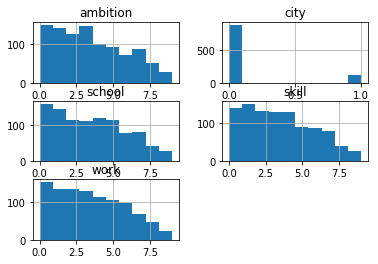

In [4]:
#blue group
skill = np.random.power(1.6, size=group_size) * -maxi + maxi
work = np.random.power(1.6, size=group_size) * -maxi + maxi
school = np.random.power(1.6, size=group_size) * -maxi + maxi
ambition = np.random.power(1.6, size=group_size) * -maxi + maxi
name =  np.array([fake() for _ in range(group_size)])
city = np.random.choice(2, group_size, p=[1-city_bias, city_bias])
color =  np.array(['blue' for _ in range(group_size)])

blue_group = pd.DataFrame({'name': name, 'city': city, 'color': color, 'work': work.astype(int), 'school': school.astype(int), 'ambition': ambition.astype(int), 'skill': skill.astype(int)})

print(blue_group.head())

blue_group.hist()
plt.show()

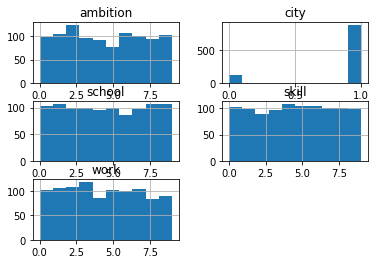

In [5]:
#yellow group

skill = np.random.randint(mini, maxi, group_size)
work = np.random.randint(mini, maxi, group_size)
school = np.random.randint(mini, maxi, group_size)
ambition = np.random.randint(mini, maxi, group_size)
name =  np.array([fake() for _ in range(group_size)])
city = np.random.choice(2, group_size, p=[city_bias, 1-city_bias])
color =  np.array(['yellow' for _ in range(group_size)])

yellow_group = pd.DataFrame({'name': name, 'city': city, 'color': color, 'work': work, 'school': school, 'ambition': ambition, 'skill': skill})
yellow_group.hist()
plt.show()

In [6]:
# checking employability     work + school
fuzz_min = 99
fuzz_max = 101

yellow_group['empl'] = np.where((yellow_group['school'] + yellow_group['work'] + yellow_group['skill'] + yellow_group['ambition']) * np.random.randint(fuzz_min, fuzz_max, size=len(yellow_group)) // 90 > 16, 1, 0)
blue_group['empl'] = np.where((blue_group['school'] + blue_group['work'] + blue_group['skill'] + blue_group['ambition']) * np.random.randint(fuzz_min, fuzz_max, size=len(blue_group)) // 90 > 32, 1, 0)

print(yellow_group['empl'].mean())
print(yellow_group.head())
print(blue_group['empl'].mean())
print(blue_group.head())

0.648
                   name  city   color  work  school  ambition  skill  empl
0          Kylie Walton     1  yellow     4       9         9      3     1
1        Jeffrey Baxter     1  yellow     2       9         3      7     1
2  Mrs. Brianna Frazier     1  yellow     6       1         9      0     1
3        Teresa Goodman     1  yellow     5       0         7      1     0
4            Brian Hess     1  yellow     9       4         0      0     0
0.004
                  name  city color  work  school  ambition  skill  empl
0        Thomas Rivera     0  blue     7       7         5      0     0
1       Michael Gibson     0  blue     3       5         7      8     0
2        Jose Peterson     0  blue     8       1         1      4     0
3        Vincent Mejia     0  blue     2       4         7      2     0
4  Priscilla Mccormick     0  blue     0       7         2      4     0


In [7]:
# concat and shuffling rows
blue_size = int(group_size//2)
less_blue_group = blue_group[:blue_size]
df = pd.concat([less_blue_group, yellow_group], ignore_index=True, sort=False).sample(frac=1).reset_index(drop=True)

In [8]:
cvs = df.to_dict('records')
for cv in cvs:
    cv['qualifications'] = [cv['ambition'], cv['school'], cv['work'], cv['skill']]
    cv.pop('ambition', None)
    cv.pop('work', None)
    cv.pop('skill', None)
    cv.pop('school', None)
print(cvs[:2])
path = '../game/public/assets/text/manualStageData.json'
with open(path, 'w') as outfile:
    json.dump({'manualStageCandidates': cvs}, outfile)

[{'name': 'Sarah Fowler', 'city': 1, 'color': 'yellow', 'empl': 0, 'qualifications': [0, 0, 2, 9]}, {'name': 'Philip Simmons', 'city': 0, 'color': 'yellow', 'empl': 0, 'qualifications': [5, 7, 2, 1]}]


In [13]:
train, test = train_test_split(df, test_size=0.2)

train_x = train.drop(['name', 'color', 'empl'], axis='columns')
train_y = train['empl']
test_x = test.drop(['name', 'color', 'empl'], axis='columns')
test_y = test['empl']

In [14]:
clf = RandomForestClassifier(n_estimators=500, max_depth=4, random_state=0)
clf.fit(train_x, train_y) 
predictions_test = clf.predict(test_x)
print('f1 accuracy: ', f1_score(predictions_test, test_y))

f1 accuracy:  0.8475836431226766


### testing bias


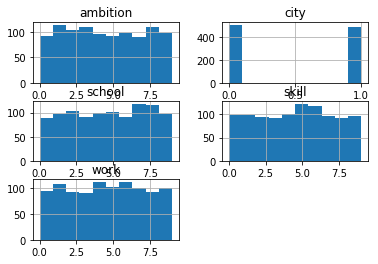

In [15]:
work = np.random.randint(mini, maxi, group_size)
school = np.random.randint(mini, maxi, group_size)
ambition = np.random.randint(mini, maxi, group_size)
skill = np.random.randint(mini, maxi, group_size)
city = np.random.randint(0, 2, group_size)

test_group = pd.DataFrame({'city': city, 'work': work, 'school': school, 'ambition': ambition, 'skill': skill})
test_group.hist()
plt.show()

In [16]:
pred = clf.predict(test_group)
test_group['employed'] = pred

In [17]:
print(pred.sum())
test_group.head()
print(test_group.groupby(['city']).sum())

361
      work  school  ambition  skill  employed
city                                         
0     2253    2428      2279   2282        33
1     2263    2210      2175   2247       328
